In [1]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from dataclasses import dataclass
import platform

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    
#     physical_devices = tf.config.list_physical_devices("GPU")
#     try:
#         tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     except:
#         # Invalid device or cannot modify virtual devices once initialized.
#         pass

    return

set_seeds()

In [3]:
# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

In [4]:
# Printing the number of devices that are in sync with the MirroredStrategy.
# This indicates how many replicas of the model are being trained in parallel.
print('Number of devices: {}'.format(DISTRIBUTE_STRATEGY.num_replicas_in_sync))

Number of devices: 2


In [5]:
def data_augmentation_preprocess():
    rand_rotation = tf.keras.layers.RandomRotation(0.15, fill_mode='nearest')

    rand_flip_hor = tf.keras.layers.RandomFlip("horizontal")

    # Adjusted Random Zoom
    rand_zoom = tf.keras.layers.RandomZoom((-0.2, 0.2))

    # Added Brightness and Contrast Variation
    rand_brightness = tf.keras.layers.RandomBrightness(0.2)
    rand_contrast = tf.keras.layers.RandomContrast(0.2)
    
    rand_shear = tf.keras.layers.RandomRotation(0.2)  # Random shear
    rand_width_shift = tf.keras.layers.RandomWidth(0.2)  # Random width shift
    rand_height_shift = tf.keras.layers.RandomHeight(0.2)  # Random height shift

    data_augmentation_pipeline = tf.keras.Sequential(
        [
            rand_rotation,
            rand_flip_hor,
            rand_zoom,
            rand_brightness,
            rand_contrast,
            rand_shear,
            rand_width_shift,
            rand_height_shift
        ]
    )

    return data_augmentation_pipeline

In [6]:
def get_data(*, data_root, target_size=(224, 224), batch_size=32, data_augmentation=False):
    
    train_path = os.path.join(data_root, "Train")
    train_dataset = image_dataset_from_directory(
        train_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle=True,
    )

    valid_path = os.path.join(data_root, "Valid")    
    valid_dataset = image_dataset_from_directory(
        valid_path, 
        label_mode='categorical',
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=target_size, 
        shuffle= False, 
    )
    
    if data_augmentation: 
        data_augmentation_pipeline = data_augmentation_preprocess()
        train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
        #valid_dataset = valid_dataset.map(lambda x, y: (data_augmentation_pipeline(x), y))
            
        
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)    
    valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, valid_dataset

In [7]:
@dataclass
class TrainingConfig:
 
    #efficient utilization of the computational power of all the devices involved in training.
    BATCH_SIZE: int = 16 * DISTRIBUTE_STRATEGY.num_replicas_in_sync

    EPOCHS: int = 100
    LEARNING_RATE: float = 0.001

    # For tensorboard logging and saving checkpoints
    root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"

    # Use multiprocessing during training.
    use_multiprocessing: bool = True if platform.system() == "Linux" else False
        
    # Number of workers to use for training.
    num_workers: int = 4

In [8]:
@dataclass
class DatasetConfig:
    DATA_ROOT: str = r"../input/opencv-TF-course-project-1-image-classification/dataset"
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 4

In [9]:
def get_callbacks(
    training_config=TrainingConfig(),
    monitor="val_loss",
    mode="min",
    save_weights_only=False,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=training_config.log_dir,
        histogram_freq=20,
        write_graph=True,
        update_freq="epoch",
        write_images=True,
    )

    
    checkpoint_filepath = training_config.checkpoint_dir
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(training_config.checkpoint_dir, "model.ckpt")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=0,
    )
    
    return [tensorboard_callback, model_checkpoint_callback]

In [10]:
def setup_log_directory(training_config=TrainingConfig()):
    '''Tensorboard Log and Model checkpoint directory Setup'''
    
    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory 
    training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(training_config.log_dir,        exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")
    
    return training_config, version_name

In [11]:
def plot_history(
    train_loss=None,
    val_loss=None,
    train_metric=None,
    val_metric=None,
    colors=["blue", "green"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(15, 10),
):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)

    train_loss_range = range(len(train_loss))
    plt.plot(
        train_loss_range,
        train_loss,
        color=f"tab:{colors[0]}",
        label=f"Train Loss",
    )

    valid_loss_range = range(len(val_loss))
    plt.plot(
        valid_loss_range,
        val_loss,
        color=f"tab:{colors[1]}",
        label=f"Valid Loss",
    )

    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title("Training and Validation Loss")

    # Mean Average Precision Plots
    plt.subplot(2, 1, 2)

    train_metric_range = range(len(train_metric))
    plt.plot(
        train_metric_range,
        train_metric,
        color=f"tab:{colors[0]}",
        label=f"Train Accuracy",
    )

    val_metric_range = range(len(val_metric))
    plt.plot(
        val_metric_range,
        val_metric,
        color=f"tab:{colors[1]}",
        label=f"Valid Accuracy",
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc=acc_legend_loc)
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show(block=block_plot)

    return

In [12]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Flatten,
    Dense,
    GlobalAveragePooling2D,
    Rescaling
)



def get_model(num_classes=4, input_shape=(224, 224, 3), name="Dummy_Model"):
    ### YOUR CODE HERE
    inputs = tf.keras.layers.Input(shape = input_shape)
    rescaled = Rescaling(1./255)(inputs)
    
    # First Convolutional Block
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation= 'relu')(rescaled)  # Output size: (, , 6)
    x = tf.keras.layers.BatchNormalization()(x)               # Output size: (, , 6)
    #x = tf.keras.layers.Activation("relu")(x)                 # Output size: (, , 6)
    x = tf.keras.layers.MaxPooling2D()(x)                        # Output size: (, , 6)

    # Second Convolutional Block
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation= 'relu')(x)     # Output size: (, , 16)
    x = tf.keras.layers.BatchNormalization()(x)               # Output size: (, , 16)
    #x = tf.keras.layers.Activation('relu')(x)                 # Output size: (, , 16)
    x = tf.keras.layers.MaxPooling2D()(x)                        # Output size: (, , 16)

    # Additional Convolutional Blocks
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation= 'relu')(x)      # Output size: (, , 32)
    x = tf.keras.layers.BatchNormalization()(x)               # Output size: (, , 32)
    #x = tf.keras.layers.Activation('relu')(x)                 # Output size: (, , 32)
    x = tf.keras.layers.MaxPooling2D()(x)                        # Output size: (, , 32)

    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation= 'relu')(x)      # Output size: (, , 64)
    x = tf.keras.layers.BatchNormalization()(x)               # Output size: (, , 64)
    #x = tf.keras.layers.Activation('relu')(x)                 # Output size: (, , 64)
    x = tf.keras.layers.MaxPooling2D()(x)  # Output size: (, , 64)
    
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation= 'relu')(x)      # Output size: (, , 64)
    x = tf.keras.layers.BatchNormalization()(x)               # Output size: (, , 64)
    #x = tf.keras.layers.Activation('relu')(x)                 # Output size: (, , 64)
    x = tf.keras.layers.MaxPooling2D()(x)                        # Output size: (, , 64)
    
    x = tf.keras.layers.Conv2D(512, 3, padding='same', activation= 'relu')(x)      # Output size: (, , 64)
    x = tf.keras.layers.BatchNormalization()(x)               # Output size: (, , 64)
    x = tf.keras.layers.Dropout(0.2)(x)
    #x = tf.keras.layers.Activation('relu')(x)                 # Output size: (, , 64)
    x = tf.keras.layers.MaxPooling2D()(x)                        # Output size: (, , 64)
    
    x = tf.keras.layers.Conv2D(1024, 3, padding='same', activation= 'relu')(x)      # Output size: (, , 64)
    x = tf.keras.layers.BatchNormalization()(x)               # Output size: (, , 64)
    x = tf.keras.layers.Dropout(0.2)(x)
    #x = tf.keras.layers.Activation('relu')(x)                 # Output size: (, , 64)
    x = tf.keras.layers.MaxPooling2D()(x)                        # Output size: (, , 64)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Flatten
    flattened = tf.keras.layers.Flatten()(x)                  # Output size: 64

    # Fully Connected Layers
    x = tf.keras.layers.Dense(240, activation='relu')(flattened)          # Output size: 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)                          # Output size: 
    x = tf.keras.layers.Dense(120, activation='relu')(x)          # Output size: 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)                          # Output size: 
    x = tf.keras.layers.Dense(84, activation='relu')(x)          # Output size: 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Softmax output layer.
    headout = tf.keras.layers.Dense(num_classes, activation="softmax")(x)  # 
    
    # Create model.
    model = tf.keras.Model(inputs=inputs, outputs=headout, name='Image_classifier')
    
    ### 
    # return your model
    return model
    
    

In [13]:
def train_model(
    dataset_config=DatasetConfig(),
    training_config=TrainingConfig(),
    data_augmentation=True,
    print_summary=True,
):

    # Get training and validation datasets.
    train_dataset, valid_dataset = get_data(
        data_root=dataset_config.DATA_ROOT,
        target_size=dataset_config.DATA_SHAPE[:2],
        batch_size=training_config.BATCH_SIZE,
        data_augmentation=data_augmentation,
    )
    
    for images, labels in valid_dataset:
        print("X Shape:", images.shape, "Y Shape:", labels.shape)
        break
        

    # # Get model
    # model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

    # # Initialize optimizer
    # optimizer = tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE)

    # # Compile model
    # model.compile(
    #     loss="categorical_crossentropy",
    #     optimizer=optimizer,
    #     metrics=["accuracy"],
    # )

    # Start a context manager using the distributed strategy previously defined.
    # This scope ensures that the operations defined within it are distributed across the available devices as per the strategy.
    with DISTRIBUTE_STRATEGY.scope():
        # Get the model by calling the 'get_model' function.
        model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

        # Compile the model. This step configures the model for training.
        # 'loss' is set to 'categorical_crossentropy', which is a common choice for classification tasks.
        # 'optimizer' is an Adam optimizer with a specific learning rate from the training configuration.
        # 'metrics' is a list of metrics to be evaluated by the model during training and testing, here it's set to track 'accuracy'.
        model.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
            metrics=["accuracy"],
        )


    # Print model summary
    if print_summary:
        model.summary()

    # Get training callbacks
    callbacks = get_callbacks(training_config)

    # Train model
    training_results = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=training_config.EPOCHS,
        callbacks=callbacks,
        workers=training_config.num_workers,
        use_multiprocessing=training_config.use_multiprocessing
    )

    print("training_results keys:", training_results.history.keys())

    return model, training_results

In [17]:
training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(training_config)
print(current_version_name)

Logging at: Logs_Checkpoints/Model_logs/version_11
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_11
version_11


In [ ]:
# Start training

trained_model, training_results = train_model(
    dataset_config=DatasetConfig(),
    training_config=training_config,
    data_augmentation=True,
)

In [ ]:
loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
    train_loss=loss,
    train_metric=accuracy,
    val_loss=val_loss,
    val_metric=val_accuracy,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

In [15]:
def recreate_model(path, load_weights=False, config=DatasetConfig(), **kwargs):
    """
    For reloading trained model
    Args:
        path: current_version checkpoint path
        load_weights: Whether the files saved at path contains model weights
                      or the Entire model configuration
        **kwargs: use to pass additional keyword arguments to the load_model method
    Returns:
        Reinitialized Trained Model
    """

    if load_weights:
        
        # Create model architecture
        model = get_model(num_classes=config.NUM_CLASSES, input_shape=config.DATA_SHAPE)

        # Load trained model best weights.
        path = os.path.join(path, "model.ckpt")
        model.load_weights(path).expect_partial()
    else:
        model = tf.keras.models.load_model(path, **kwargs)

    model.summary()
    return model

In [18]:
load_version = "version_8"
checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version) 

trained_model = recreate_model(checkpoint_path)

Model: "Image_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32) 

In [19]:
def get_sample_predictions(*, model, dataset, total=15):

    imgs = []
    ground_truths = []
    probs = []
    predictions = []

    idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

    print("Generating Predictions...")
    for data, target in dataset:
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)
    
        imgs.extend(data.numpy() / 255.)
        ground_truths.extend(target.numpy())
        predictions.extend(cls_predicted)
        probs.extend(cls_probs)
        
        # Displaying only 15 images 
        if data.shape[0] >= total: 
            break

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (18, 9)
    fig = plt.figure()
    fig.set_facecolor("white")

    for idx in range(total):

        plt.subplot(3, 5, idx + 1)
        img = imgs[idx]
        plt.imshow(img)

        plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
        plt.axis("off")

    fig.savefig("sample_predictions.png")
    plt.show(block=block_plot)
    
    del imgs, ground_truths, probs, predictions
    return

Found 786 files belonging to 4 classes.
Generating Predictions...


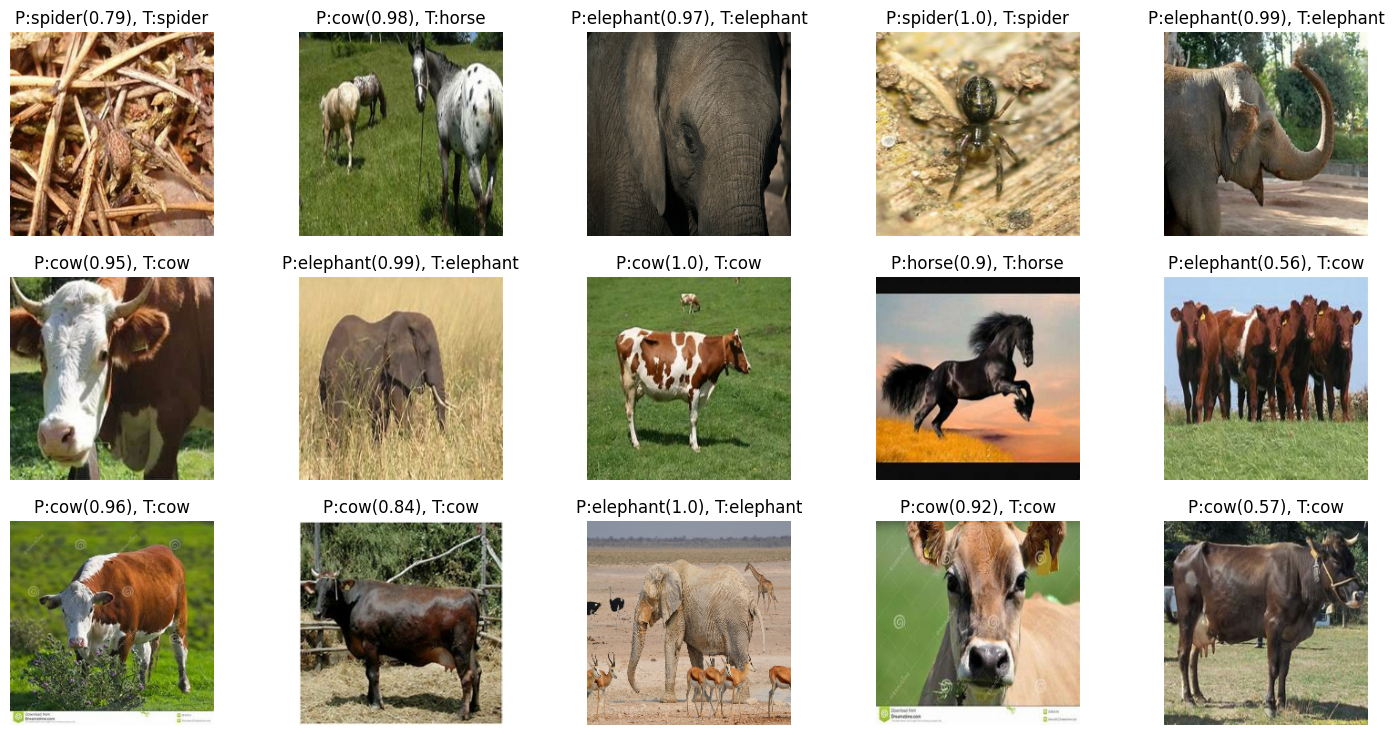

In [20]:
data_config = DatasetConfig()
training_config = TrainingConfig()

valid_path = os.path.join(data_config.DATA_ROOT, "Valid")

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    label_mode='int',
    color_mode='rgb', 
    batch_size=training_config.BATCH_SIZE, 
    image_size=data_config.DATA_SHAPE[:2], 
    shuffle=True, # shuffling to show images from all classes
)

get_sample_predictions(model=trained_model, dataset=valid_dataset)

In [21]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(*, model, dataset):
    predictions = []
    ground_truths = []
    
    print("Generating Confusion Matrix:")
    for data, target in dataset:
        
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        
        predictions.extend(cls_predicted)
        ground_truths.extend(target.numpy())
        
    
    cm= confusion_matrix(ground_truths, predictions)
    class_names = ["cow", "elephant", "horse", "spider"]
    
    #plot the confusion matrix:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


###

Generating Confusion Matrix:


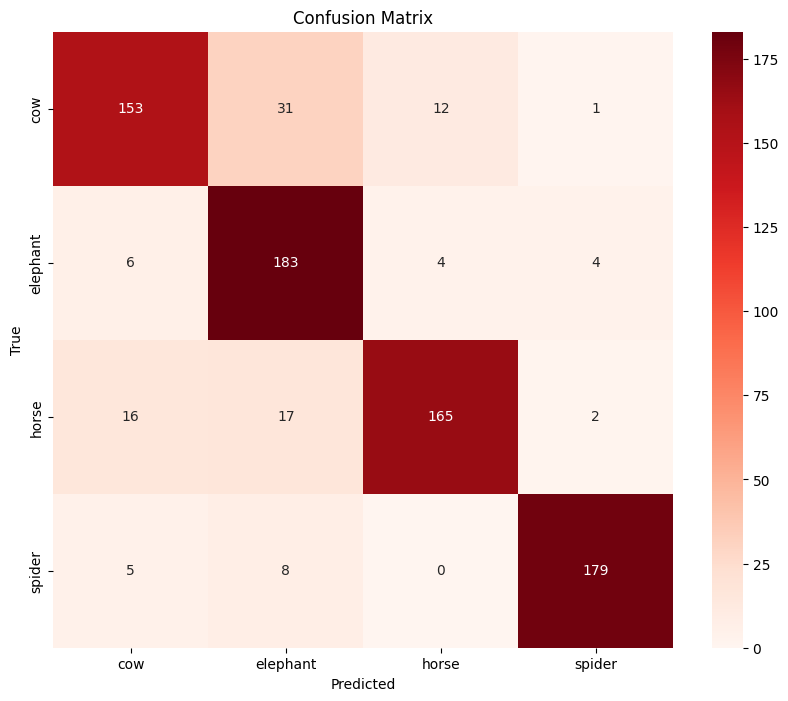

In [22]:
plot_confusion_matrix(model=trained_model, dataset=valid_dataset)

In [23]:
import csv
import pandas as pd


data = pd.read_csv("/kaggle/input/opencv-TF-course-project-1-image-classification/test.csv")
idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

with open("submission.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "CLASS"])

    for i, row in data.iterrows():
        img_path = os.path.join("/kaggle/input/opencv-TF-course-project-1-image-classification/dataset", "Test", row["ID"])
        img = tf.keras.utils.load_img(img_path, target_size=(224, 224), interpolation="bilinear")
        img = tf.keras.utils.img_to_array(img)
        img = np.array([img]) #model.predict expects a batch size so expand the dimension 

        model_predictions = trained_model.predict(img, verbose=False)
        cls_predicted = np.argmax(model_predictions[0], axis=-1)
        writer.writerow([row["ID"], idx_to_cls[cls_predicted]])